# Term Paper

### Part 1

In [1]:
import pandas as pd
import glob as glob

In [2]:
files=glob.glob(f'data/SCE-*-20*.csv')

df_list=[]

waves_number=0

#Loop to read in and append files
for file in files:
    df=pd.read_csv(file,sep=";",parse_dates=['date'])
    df_list.append(df)


sce_df=pd.concat(df_list,ignore_index=True)

# Setting date as index and sorting
sce_df.set_index('date',inplace=True)
sce_df.sort_index(inplace=True)


def compute_statistics():
    num_individuals = sce_df["userid"].nunique() # Number of Unique userids (individuals)
    num_observations = len(sce_df)               # Total number of observations
    num_waves = sce_df["wid"].nunique()          # Number of Unique survey waves          
    first_date = sce_df.index[0]                 # Earliest survey date
    last_date = sce_df.index[-1]                 # Latest survey date

    # Output the statistics
    print("\nDataset Statistics")
    print(f"Unique individuals: {num_individuals}") 
    print(f"Total observations: {num_observations}")
    print(f"Unique survey waves: {num_waves}")
    print(f"Date range: {first_date.date()} to {last_date.date()}") # date() to show only date, not 00.00.00

compute_statistics()



Dataset Statistics
Unique individuals: 23369
Total observations: 176101
Unique survey waves: 139
Date range: 2013-06-01 to 2024-12-31


### Part 2

In [3]:
# Forward-fill numeracy variables for each individual
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]

# Replace blank strings with NaN (if your CSV uses empty fields)
sce_df[numeracy_cols] = sce_df[numeracy_cols].replace("", pd.NA)


# Group by userid, then forward-fill within each person
sce_df[numeracy_cols] = sce_df.groupby('userid')[numeracy_cols].ffill()

#NOTE: Here should add variable for demographics (Female, age, educ), and economic variables (inf,house,prob) for later tasks

# Drop all rows that still have NaN
numeracy_cols.extend(['female','educ','age','inflation','house_price_change','prob_stocks_up'])
sce_df.dropna(subset=numeracy_cols,inplace=True)

#Eliminate 0.1th percentile and 99.9th percentile of answers for Inflation, 
expectation_cols = [
    'inflation','house_price_change','prob_stocks_up' # changed order of house and prob stocks to: house then prob for graph
]
lower_bounds=sce_df[expectation_cols].quantile(0.001)
upper_bounds=sce_df[expectation_cols].quantile(0.999)  #NOTE:should probably remove outliers from normancy aswell
for col in expectation_cols:                           
    sce_df=sce_df[(sce_df[col]>lower_bounds[col]) & (sce_df[col]<upper_bounds[col])] 

#Creating a column to determine whether the individual has a bachelor's degree or higher
sce_df['college']=(sce_df['educ']>3).astype(int)

#Compute the total number of correct numeracy responces
sce_df['numeracy_score']=sce_df[numeracy_cols].sum(axis=1)

#Compute the average numeracy score
percentage=sce_df['numeracy_score'].value_counts(normalize=True)*100
percentage.sort_index(inplace=True)
print(f"Numeracy Score Distribution (%): {percentage}")

#Creating a column to determine if the individual has a higher numeracy score than the median
median_score = sce_df['numeracy_score'].median()
sce_df['num_lit_high'] = (sce_df['numeracy_score'] > median_score).astype(int)

# compute and print statistics again after cleaning
compute_statistics()

Numeracy Score Distribution (%): numeracy_score
-61.0     0.000744
-51.0     0.000744
-49.0     0.000744
-44.0     0.000744
-36.0     0.000744
            ...   
 341.0    0.000744
 358.0    0.000744
 510.0    0.000744
 562.0    0.000744
 773.0    0.000744
Name: proportion, Length: 1360, dtype: float64

Dataset Statistics
Unique individuals: 17608
Total observations: 134398
Unique survey waves: 117
Date range: 2015-04-02 to 2024-12-31


# Part 3

In [4]:
import matplotlib.pyplot as plt
#NOTE: Define constants outside the function, or earlier in document
#NOTE: remember to have uniform use of "" not '' in document

# Function to plot bar charts of expectations by group
def plot_expectation_bars_by_group(group_var, group_labels, Colors):
   
    # Calculate mean expectations by group_var (eg. female, college, num_lit_high)
    grouped = sce_df.groupby(group_var)[expectation_cols].mean()
    grouped.index = group_labels       #NOTE: ["inflation", etc list can be made into variable, and]           

    # Creates sublots for each expectation variable. 
    # Variables fig for the whole figure, axes for each subplot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Create list of titles and y_labels to loop trough 
    titles = ["Inflation", "House Price", "Stock Market"] # NOTE: use variable list with some .upper() to get titles
    y_labels = ["Inflation (%)", "House Price Change (%)", "Probability Stocks Up (%)"]
    # loops trough i (index) and var (variables) in enumerate of variables list
    for i, var in enumerate(expectation_cols):
        # Plots bar chart 
        grouped[var].plot.bar(ax=axes[i], color=Colors, rot=0,) #rot=0 to keep x labels horizontal since df.plot.bar defaults to rot=45
                                          #NOTE can change color to function variable to change colors like ax
        # Sets title and y label for each subplot 
        axes[i].set_title(f"{titles[i]} Expectations", fontsize=12, fontweight="bold", pad=15) #maybe remove pad, adds space between title and plot
        axes[i].set_ylabel(y_labels[i]) #NOTE: maybe add fontsize

        # Adds grid lines for better readability, and set axis below so grid doesnt obsucre data
        axes[i].grid(axis="y", linestyle="--", alpha=0.3)
        axes[i].set_axisbelow(True)   

    plt.tight_layout()
    plt.show()

    

# Expectations by Demographic Groups

The following graphs compare the average expectations for inflation, house price changes, and stock market performance based on different demographic groups.


## Gender

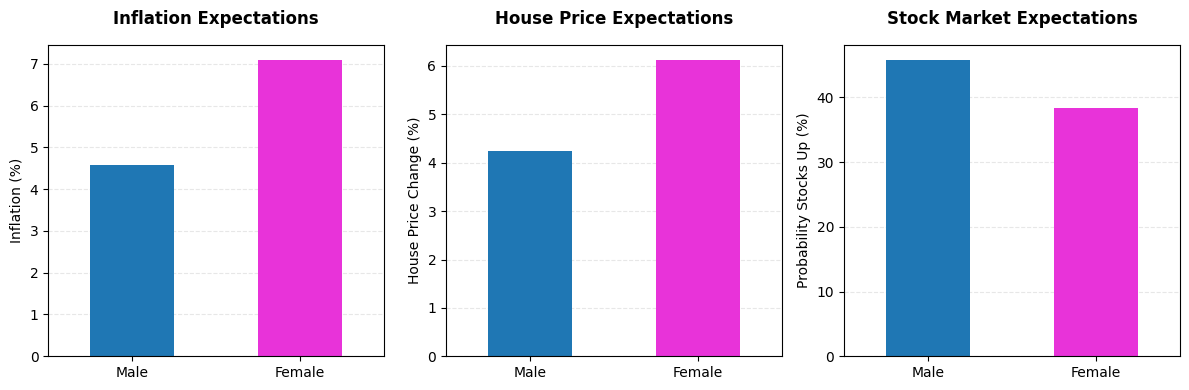

## Education

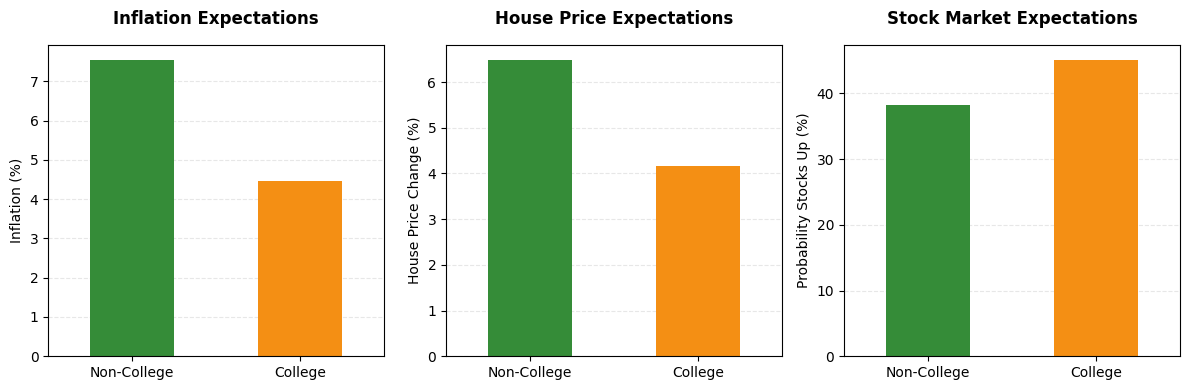

## Numeracy

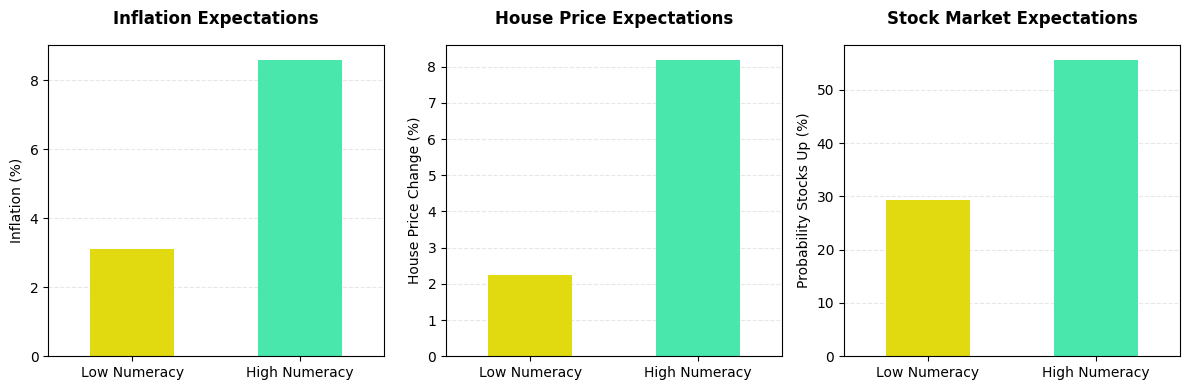

In [5]:
from IPython.display import display, Markdown # Import display to use markdown headers
# Main header and description
display(Markdown("# Expectations by Demographic Groups"))
print("The following graphs compare the average expectations for inflation, house price changes, and stock market performance based on different demographic groups.")

# Gender Comparison
display(Markdown("## Gender"))
plot_expectation_bars_by_group('female', ['Male', 'Female'], ['#1f77b4', "#e833d9"])

# Education Level Comparison
display(Markdown("## Education"))
plot_expectation_bars_by_group('college', ['Non-College', 'College'], ["#358c38", "#f48f14"])

# Numeracy Comparison
display(Markdown("## Numeracy"))
plot_expectation_bars_by_group('num_lit_high', ['Low Numeracy', 'High Numeracy'], ["#e1da10", "#4AE7AD"])

## Analysis

dfdfsdf